## Clustering Methods in Python
#### Authors: Lucas Joseph, Nikhil Kuniyil, Johnson Sy Leung, Katsuri Sharma, Daniel Yan
In this vignette, we will be comparing three different clustering methods in python. We will be demonstrating this using a data set that deals with user behavior depending on what kind of phone they have.

### Objective:

___
## Data Description:
The dataset represents user behavior data collected from various mobile devices and includes 12 attributes for 188 users. Key attributes include Device Model, Operating System, and demographic information such as Age and Gender, alongside numerical metrics that measure daily device usage. These numerical metrics include App Usage Time (min/day), Screen On Time (hours/day), Battery Drain (mAh/day), Number of Apps Installed, and Data Usage (MB/day). Additionally, each user is assigned a User Behavior Class, which categorizes their usage patterns into five distinct classes.

The dataset provides a mix of categorical and numerical features, making it suitable for various clustering and classification analyses. The categorical features, such as Device Model and Operating System, allow for insights into behavioral differences across devices and platforms, while the numerical features provide detailed quantitative data on user interaction with their devices. With its diverse set of attributes, this dataset offers opportunities to explore user segmentation, predict user behavior patterns, and analyze correlations between usage habits and demographics.

___
## Clustering Methods:
Clustering is a type of unsupervised machine learning that is used to group similar data points into unique clusters. Although the way in which similarity is determined varies between the different clustering methods, the end goal is still sorting data points in a way thhat maximizes similarity within a cluster while minimizing similarity between clusters.

Clustering can be used in many contexts as the unsupervised nature of the method means that it is very flexible. Some of the possible uses of clustering methods include fraud detection, crime analysis, and finance.

We will be comparing three different clustering methods today: k means, spectral, and agglomerative.

___
### K-Means Clustering:
K-Means clustering is a partitioning clustering algorithm that in principle is similar to the supervised machine learning method K-Nearest Neighbors. 

Following the classic k-means algorithm or "naive k-means", the method involves randomly selecting K points to serve as cluster centers or *centroids* and then assigning each point in the dataset to its nearest cluster using Euclidiean distance. The location of centroids are then recalculated to be the mean of all items within the cluster, and each point will be reassigned to its nearest cluster. The process of recalculating the centroid location and assigning clusters is repeated until cluster assignments stop significantly changing.

Though there are many different means of choosing initial centroid locations, we chose to use **k-means++ initialization**. This method involves selecting a random centroid, computing the distance between each point and the centroid, then selecting the location for the next centroid from datapoint with a probability proportional to the distance squared from the closest existing centroid. This is repeated k times and ensures that the centroids are less likely to be close together.

The naive k-means algorithm has faster alternatives and is not guaranteed to find the optimum clusters(FIND SOURCE)

#### Implementation
We begin the implementation by importing the transformed dataset, scaling all variables, and then performing principle components analysis to reduce the dimensionality of our dataset.

In [87]:
# Import relevant packages
from sklearn.cluster import KMeans # type: ignore
from sklearn.metrics import silhouette_score # type: ignore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt

# Read in data
df_transformed = pd.read_csv('../data/transformed_user_behavior_dataset.csv')
df = pd.read_csv('../data/user_behavior_dataset.csv')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed)

# PCA 
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(X_scaled)
print(pca_2.explained_variance_ratio_) # Explain this stat

[0.39939424 0.18529069]


We also find that by PCA to 2 components, components PC1 and PC2 account for roughly 39.94% and 18.53% of the variance in the data respectively.

We then must decide how many clusters are appropriate for our data. To do this, we employ *the elbow method* and examine the *silhouette scores of the k-means model for each number of clusters. 

- **The elbow method** finds the optimal number of clusters by running k-means clustering for different values of k, then selecting for a number of clusters where the sum of squared distances between points and their cluster(within cluster sum of squares/WCSS) does not drop significantly with the addition of more clusters.
- A **silhouette score** is the mean Euclidian distance between each point within a cluster. We will plot the average silhouette score across all clusters for different values of K to inform our choice of K.

Here we initialize 10 different K-means models using k-means++ initialization and evaluate the resulting WCSS and silhouette scores.

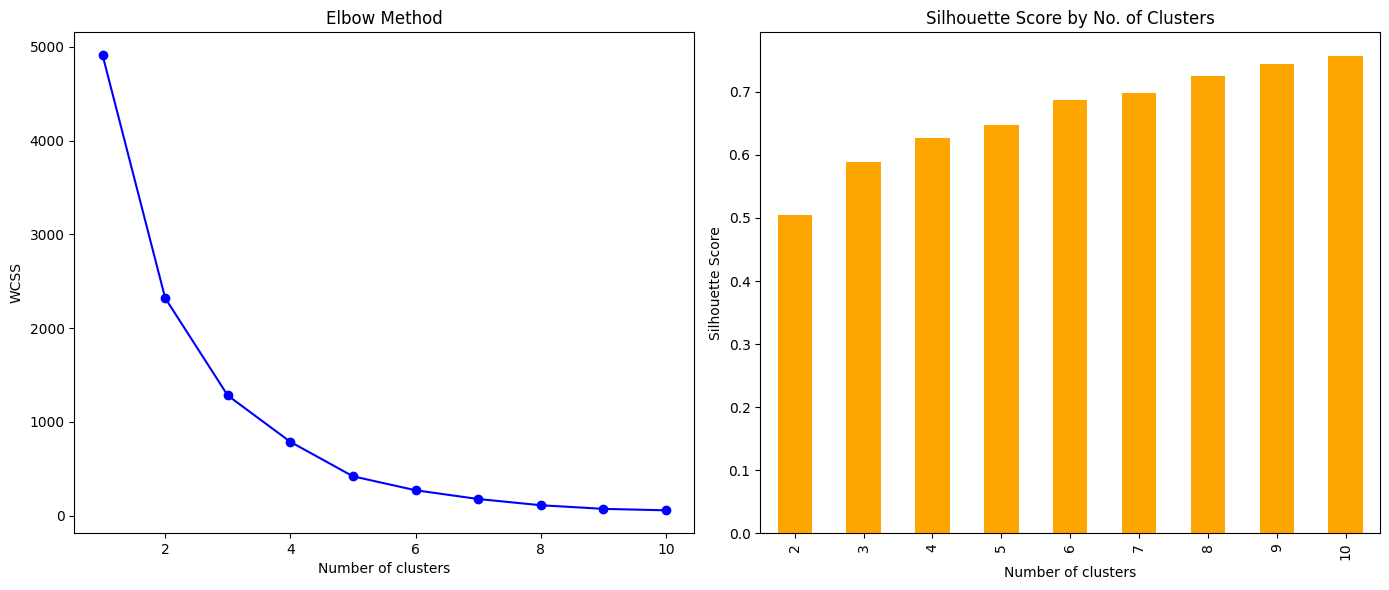

In [88]:
# Use elbow method to find optimal number of clusters
wcss = [] # average within cluster sum of squares
silhouette_scores = []
models = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0) # n_init: Number of times the k-means algorithm is run with different centroid seeds
    kmeans.fit(pca_2_result)
    wcss.append(kmeans.inertia_) # inertial is the wcss for a given number of clusters
    models.append(kmeans)  

    if i > 1:
        labels_i = kmeans.labels_
        silhouette_avg_i = silhouette_score(pca_2_result, labels_i)
        silhouette_scores.append(silhouette_avg_i)

# Display plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Elbow Plot
axs[0].plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('WCSS')

# Silhouette Plot
silhouette_df = pd.DataFrame({"silhouette_score": silhouette_scores, "no_clusters": range(2, 11)})
silhouette_df.plot(x='no_clusters', y='silhouette_score', kind='bar', ax=axs[1], legend=False, color='orange')
axs[1].set_title('Silhouette Score by No. of Clusters')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Silhouette Score')

# Save fig
plt.tight_layout()
plt.savefig('../img/fig-combined_elbow_silhouette.png')
plt.show()

The left figure shows that the within cluster sum of squares begins stop decreasing dramatically at around 5 or 6 clusters. We also see that the right figure shows that 6 clusters leads to a silhouette score of roughly .68. We'll choose the k-means model with 6 clusters to evaluate. 

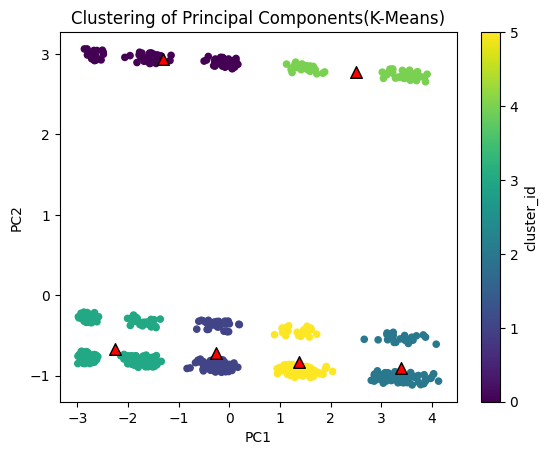

Silhouette score for K-means model: 0.6869174226355345


In [89]:
# Applying K-Means++ initialization
n_clusters = 6

kmeans = models[n_clusters - 1]
labels = kmeans.labels_

# Visualization using PCA 
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids)
centroids_df = centroids_df.rename(columns={0: "PC1", 1:"PC2"})  

viz = pd.DataFrame(pca_2_result)
viz['cluster_id'] = labels
viz = viz.rename(columns={0: "PC1", 1:"PC2"})    
viz.plot.scatter('PC1', 'PC2', c=2, colormap='viridis')

plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', s=70, linewidths=1,
                color='red', edgecolors="black")
plt.title('Clustering of Principal Components(K-Means)')
plt.savefig('../img/fig-k-means-clusters-PCA.png')
plt.show()

# Metrics 

df_km = df_transformed
df_km['Cluster'] = labels

silhouette_avg_km = silhouette_score(pca_2_result, labels)
print(f"Silhouette score for K-means model: {silhouette_avg_km}")

___
### Agglomerative Hierarchical Clustering:
Agglomerative clustering is a type of hierarchical clustering which aims to build a hierarchy of clusters in a "bottom-up" fashion. Each data point is initially labeled as its own separate clusters. Each datapoint has its distance between all other points calculated, and then merges with the closest point to form a new cluster. This process repeats until all clusters have merged into one. 

Agglomerative clustering can use different distance metrics as well as linkage criterias to define similarity between clusters allowing for more flexibility and powerful when compared to K-means clustering. 

One of the main drawbacks of agglomerative clustering is that it can be very computationally expensive due to each observation starting as its own cluster.

Below we construct a dendrogram for our data after scaling and performing PCA. A dendrogram is the resulting tree of clusters created after linking points. We use Euclidian distance as the distance metric, and the median linkage method, which sets the new centroid after joining clusters to be the median point between the two clusters. 

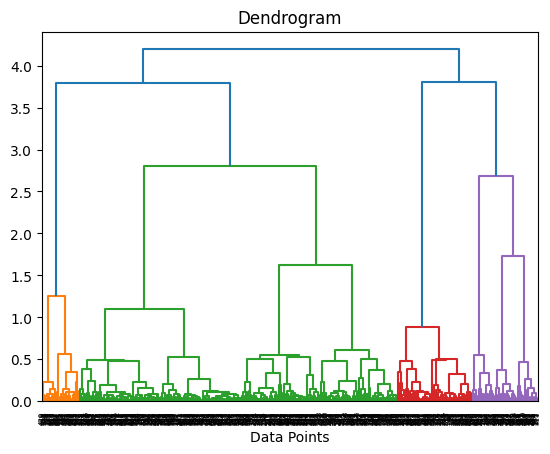

In [90]:
# agglomerative script
from sklearn.cluster import AgglomerativeClustering 
import scipy.cluster.hierarchy as shc

# Read in data
df_transformed = pd.read_csv('../data/transformed_user_behavior_dataset.csv')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed)

# Generate dendrogram
dend = shc.dendrogram(shc.linkage(pca_2_result, method='median')) # why use ward? 
plt.title("Dendrogram")
plt.xlabel("Data Points")
plt.savefig("../img/fig-dendrogram.png")
plt.show()

We select 6 clusters because...

We can now visualize the clusters.

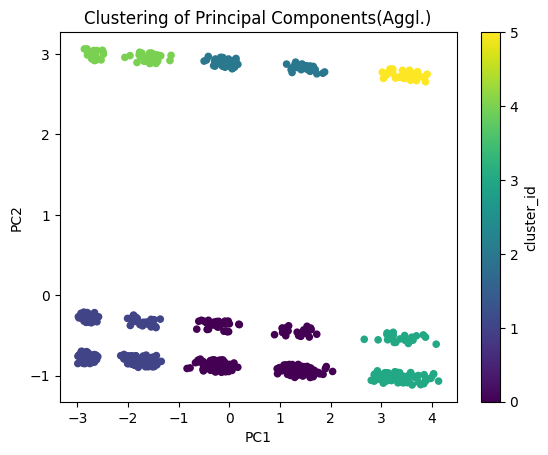

Silhouette score for Agglomerative Hierarchical Model: 0.658934359393889


In [91]:
# Build Agglomerative model and visualize
n_clusters = 6 
agglom = AgglomerativeClustering(n_clusters=n_clusters).fit(pca_2_result) 
labels = agglom.labels_

# centroids = agglom.cluster_centers_
# centroids_2 = pca_2.fit_transform(centroids)

viz = pd.DataFrame(pca_2_result)
viz['cluster_id'] = labels
viz = viz.rename(columns={0: "PC1", 1:"PC2"})

viz.plot.scatter('PC1', 'PC2', c=2, colormap='viridis')

#plt.scatter(centroids_2[:, 0], centroids_2[:, 1], marker='X', s=200, linewidths=1.5,
#                color='red', edgecolors="black")
plt.title('Clustering of Principal Components(Aggl.)')
plt.savefig('../img/fig-agglom-PCA.png')
plt.show()

df_agg = df_transformed
df_agg['Cluster'] = labels

silhouette_avg_agg = silhouette_score(pca_2_result, labels)
print(f"Silhouette score for Agglomerative Hierarchical Model: {silhouette_avg_agg}")

___
### Spectral Clustering:
Spectral clustering is an advanced clustering technique that leverages the eigenvalues and eigenvectors of a similarity matrix to group data points based on their relationships, making it particularly effective for non-convex or complex datasets. Unlike traditional methods like k-means, spectral clustering identifies clusters by embedding the data in a lower-dimensional space, revealing hidden structures within the dataset.

In the context of our dataset, spectral clustering can be used to group users into behavior-based segments by considering both categorical features, such as Device Model and Operating System, and numerical features like App Usage Time and Screen On Time. By constructing a similarity matrix based on these features, spectral clustering can uncover intricate patterns in user behavior, identifying clusters that may not be immediately apparent with simpler methods. This approach is particularly useful given the mix of categorical and numerical data, as it allows for a holistic understanding of the relationships between user demographics and device usage habits.

In [92]:
import sys
sys.path.append('../scripts')
import spectral_script
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
data = '../data/transformed_user_behavior_dataset.csv'

# perform spectral clustering
df_sp = spectral_script.perform_spectral_clustering(data)

df_sp.head()

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Device Model_OnePlus 9,Device Model_Samsung Galaxy S21,Device Model_Xiaomi Mi 11,Device Model_iPhone 12,Operating System_iOS,Gender_Male,Cluster
0,393.0,6.4,1872.0,67.0,1122.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,4
1,268.0,4.7,1331.0,42.0,944.0,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,154.0,4.0,761.0,32.0,322.0,42.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,239.0,4.8,1676.0,56.0,871.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,4
4,187.0,4.3,1367.0,58.0,988.0,31.0,0.0,0.0,0.0,1.0,1.0,0.0,3


In [94]:
# mean of each feature group by cluster
df_sp.groupby('Cluster').mean()

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Device Model_OnePlus 9,Device Model_Samsung Galaxy S21,Device Model_Xiaomi Mi 11,Device Model_iPhone 12,Operating System_iOS,Gender_Male
Cluster,,,,,,,,,,,,
0,270.383459,5.241353,1523.849624,49.969925,911.120301,38.879699,1.0,0.0,0.000000,0.0,0.0,0.541353
1,312.811429,6.052000,1713.708571,56.371429,1107.000000,38.177143,0.0,0.0,0.834286,0.0,0.0,0.497143
2,266.421053,5.318045,1504.571429,50.804511,931.872180,39.112782,0.0,1.0,0.000000,0.0,0.0,0.593985
3,282.020548,5.430822,1589.513699,52.726027,965.506849,38.958904,0.0,0.0,0.000000,1.0,1.0,0.493151
4,198.920354,3.845133,1175.778761,39.920354,628.433628,37.132743,0.0,0.0,0.000000,0.0,0.0,0.477876


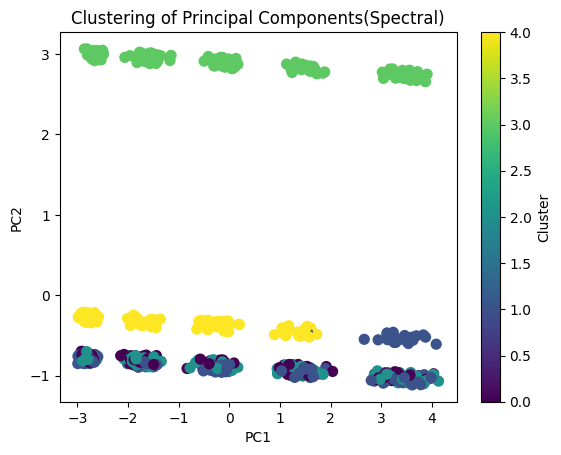

Silhouette score for Spectral Model: 0.21179965122376113


In [95]:
# Reduce dimensions for visualization
df_transformed = pd.read_csv(data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_with_clusters['Cluster'], cmap='viridis', s=50)
plt.title("Clustering of Principal Components(Spectral)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.savefig('../img/fig-spectral-PCA.png')
plt.show()

silhouette_avg_sp = silhouette_score(X_scaled, labels)
print(f"Silhouette score for Spectral Model: {silhouette_avg_sp}")

##### Cluster Analysis
After performing the spectral clustering, our data has been divided into five clusters. We analyze the traits and characteristics of each cluster below:

<b>Cluster 0:</b> 

<b>• Usage Patterns:</b> Moderate daily app usage (around 270 min/day) and screen time (~5.2 hrs/day) with moderate battery drain and data usage.

<b>• Demographics:</b> Slightly above 50% male, average age around 39.

<b>• Platform/OS:</b> Strongly skewed towards OnePlus 9 (1.0 in that category), no iOS users.

<b>• Interpretation:</b> This cluster represents moderately engaged users who predominantly use OnePlus 9 devices. Their balanced usage suggests they are steady, regular users rather than extreme power users or casual browsers.

<b>Cluster 1:</b>

<b>• Usage Patterns:</b> Higher daily usage (~313 min/day) and screen-on time (~6 hrs/day) with increased battery drain and data usage (~1107 MB/day).

<b>• Demographics:</b> About half male, average age ~38.2.

<b>• Platform/OS:</b> Predominantly Xiaomi Mi 11 users, no iOS.

<b>• Interpretation:</b> A segment of heavier Android (Xiaomi Mi 11) users who consume large amounts of data and battery. Ideal for advanced features, exclusive promotions, or data-saving options.

<b>Cluster 2:</b>

<b>• Usage Patterns:</b> Similar to Cluster 0, moderate daily usage (~266 min/day, 5.3 hrs/day) with moderate-to-high battery drain and data usage.

<b>• Demographics:</b> About 59% male, average age ~39.1.

<b>• Platform/OS:</b> Primarily Samsung Galaxy S21 users, no iOS.

<b>• Interpretation:</b> Another Android-focused cluster with moderate engagement. Users may appreciate performance optimizations or targeted recommendations tailored to their Samsung Galaxy S21 experience.

<b>Cluster 3:</b>

<b>• Usage Patterns:</b> Moderately high usage (~282 min/day, 5.4 hrs/day), moderate-to-high battery drain and data usage.

<b>• Demographics:</b> Roughly half male, average age ~39.

<b>• Platform/OS:</b> Exclusively iPhone 12 and iOS users.

<b>• Interpretation:</b> An Apple-centric cluster of moderately engaged iOS users. May respond well to premium services, ecosystem integrations, and features that leverage Apple’s platform strengths.

<b>Cluster 4:</b>

<b>• Usage Patterns:</b> Lower daily app usage (~199 min/day) and screen-on time (~3.8 hrs/day), lower battery and data usage.

<b>• Demographics:</b> Slightly younger (avg age ~37), about 48% male.

<b>• Platform/OS:</b> No strong device model associations or iOS usage. Likely a mix of various Android devices.

<b>• Interpretation:</b> A segment of lighter users who might benefit from educational content, feature discovery, and engagement campaigns to increase their usage and involvement over time.

___
### Clustering Evaluation
Finally, let's compare our three clustering methods and their respective clusters:
|![K-Means Clusters](../img/fig-k-means-clusters-PCA.png) |![Agglomerative Clusters](../img/fig-agglom-PCA.png) |![Spectral Clusters](../img/fig-spectral-PCA.png) |
|-|-|-|

In [96]:
df_km_avg = df_km.groupby('Cluster').mean().assign(Method='K-means')
df_agg_avg = df_agg.groupby('Cluster').mean().assign(Method='Agglomerative')
df_sp_avg = df_sp.groupby('Cluster').mean().assign(Method='Spectral')

results = pd.concat([df_km_avg, df_agg_avg, df_sp_avg])
results.head(18)

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Device Model_OnePlus 9,Device Model_Samsung Galaxy S21,Device Model_Xiaomi Mi 11,Device Model_iPhone 12,Operating System_iOS,Gender_Male,Method
Cluster,,,,,,,,,,,,,
0,157.872093,3.334884,999.174419,33.465116,527.604651,39.767442,0.000000,0.000000,0.000000,1.0,1.0,0.500000,K-means
1,234.720721,4.977477,1521.693694,49.828829,820.261261,38.378378,0.225225,0.189189,0.288288,0.0,0.0,0.423423,K-means
2,543.342857,10.184762,2693.057143,89.009524,1984.771429,38.142857,0.247619,0.219048,0.276190,0.0,0.0,0.571429,K-means
3,94.372807,2.261404,669.864035,22.855263,326.964912,38.114035,0.245614,0.245614,0.254386,0.0,0.0,0.552632,K-means
4,459.966667,8.435000,2435.666667,80.333333,1593.166667,37.800000,0.000000,0.000000,0.000000,1.0,1.0,0.483333,K-means
5,399.936364,6.913636,2101.218182,69.918182,1235.072727,39.045455,0.236364,0.300000,0.245455,0.0,0.0,0.536364,K-means
0,316.954751,5.941176,1810.144796,59.828054,1026.728507,38.710407,0.230769,0.244344,0.266968,0.0,0.0,0.479638,Agglomerative
1,94.372807,2.261404,669.864035,22.855263,326.964912,38.114035,0.245614,0.245614,0.254386,0.0,0.0,0.552632,Agglomerative
2,305.311475,5.837705,1792.098361,59.786885,1015.098361,38.557377,0.000000,0.000000,0.000000,1.0,1.0,0.442623,Agglomerative


Let's also examine the silhouette score for each method in order to assess how similar points within each cluster are:

- **For K-means clustering**, the silhouette score was **0.687**
- **For agglomerative hierarchical clustering**, the silhouette score was **0.659**
- **For spectral clustering**, the silhouette score was **0.212**

This means that our K-means clustering algorithm had clusters which had the least amount of distance between points compared to the other two methods.

___

## Conclusion
We have successfully used three clustering techniques in order to generate groups of cell phone users with similar usage patterns!

(Talk about the pros and cons of each method and why one method might have done better over another)